WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation : [0.7505746890144682,0.660785620463123,0.3937171930045058,0.9192316203942578,-0.5993888120992774,-1.8852822595476093], Reward: 0
Observation : [0.8409230091027716,0.5411547770846524,0.7684599755528647,0.6398978558905246,-0.8095031727187878,-2.951346858485797], Reward: -1
Observation : [0.9115733073889121,0.4111375746098136,0.9991383557679806,-0.04150356651248497,-0.7923558714393711,-4.07419215111344], Reward: -1
Observation : [0.9880993474685513,0.153817032646658,0.7790997584500674,-0.6268999652121912,-1.9698559101785635,-1.9593246837302338], Reward: -1
Observation : [0.949744511541202,-0.3130261375626063,0.6764442131544547,-0.7364938740341638,-2.586148407803113,0.32775072482350076], Reward: -1
Observation : [0.6922511488225229,-0.7216566683360567,0.8046544001469603,-0.593743460026412,-2.1421392524577327,1.3326668142944404], Reward: -1
Observation : [0.4167897269754165,-0.909

Text(0,0.5,'Joint Velocities')

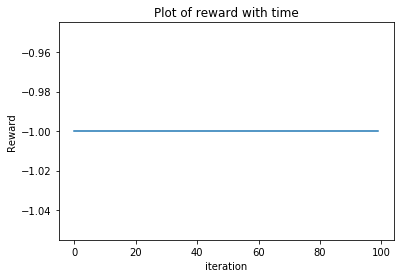

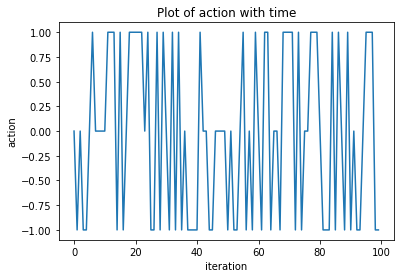

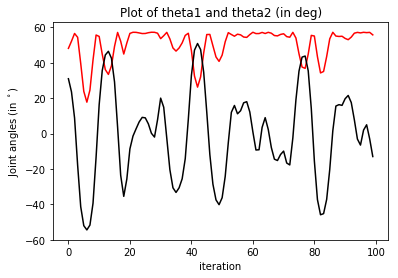

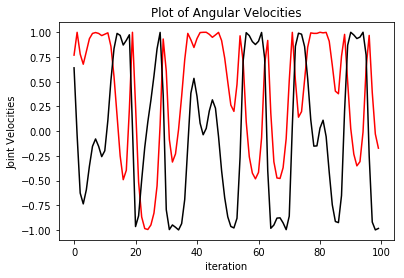

In [15]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep  4 03:08:22 2018

@author: sreen
"""
from gym import core, spaces
from gym.utils import seeding
import numpy as np
from numpy import sin, cos, pi
import time
import matplotlib.pyplot as plt
%matplotlib inline

class AcrobotEnv(core.Env):

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : 15
    }

    dt = .2

    LINK_LENGTH_1 = 1.  # [m]
    LINK_LENGTH_2 = 1.  # [m]
    LINK_MASS_1 = 1.  #: [kg] mass of link 1
    LINK_MASS_2 = 2.  #: [kg] mass of link 2
    LINK_COM_POS_1 = 0.5  #: [m] position of the center of mass of link 1
    LINK_COM_POS_2 = 0.5  #: [m] position of the center of mass of link 2
    LINK_MOI = 1.  #: moments of inertia for both links

    MAX_VEL_1 = 4*pi
    MAX_VEL_2 = 9*pi

    AVAIL_TORQUE = [-1., 0., +1]

    torque_noise_max = 0.

    action_arrow = None
    domain_fig = None
    actions_num = 3

    def __init__(self):
        self.viewer = None
        high = np.array([1.0, 1.0, 1.0, 1.0, self.MAX_VEL_1, self.MAX_VEL_2])
        low = -high
        self.observation_space = spaces.Box(low, high)
        self.action_space = spaces.Discrete(3)
        self.state = None
        self._seed()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.state = self.np_random.uniform(low=-np.pi, high= np.pi, size=(4,))
        return self._get_ob()

    def step(self, a):
        s = self.state
        torque = self.AVAIL_TORQUE[a]

        # Add noise to the force action
        if self.torque_noise_max > 0:
            torque += self.np_random.uniform(-self.torque_noise_max, self.torque_noise_max)

        s_augmented = np.append(s, torque)

        ns = rk4(self._dsdt, s_augmented, [0, self.dt])
        # only care about final timestep of integration returned by integrator
        ns = ns[-1]
        ns = ns[:4]

        ns[0] = wrap(ns[0], -pi, pi)
        ns[1] = wrap(ns[1], -pi, pi)
        ns[2] = bound(ns[2], -self.MAX_VEL_1, self.MAX_VEL_1)
        ns[3] = bound(ns[3], -self.MAX_VEL_2, self.MAX_VEL_2)
        self.state = ns
        terminal = self.isterminal()
        reward = -1. if not terminal else 0.
        return (self._get_ob(), reward, terminal, {})

    def _get_ob(self):
        s = self.state
        return np.array([cos(s[0]), np.sin(s[0]), cos(s[1]), sin(s[1]), s[2], s[3]])

    def isterminal(self):
        s = self.state
        return bool(-np.cos(s[0]) - np.cos(s[1] + s[0]) > 1.)

    def _dsdt(self, s_augmented, t):
        m1 = self.LINK_MASS_1
        m2 = self.LINK_MASS_2
        l1 = self.LINK_LENGTH_1
        lc1 = self.LINK_COM_POS_1
        lc2 = self.LINK_COM_POS_2
        I1 = self.LINK_MOI
        I2 = self.LINK_MOI
        g = 9.8
        a = s_augmented[-1]
        s = s_augmented[:-1]
        theta1 = s[0]
        theta2 = s[1]
        dtheta1 = s[2]
        dtheta2 = s[3]
        d1 = m1 * lc1 ** 2 + m2 * \
            (l1 ** 2 + lc2 ** 2 + 2 * l1 * lc2 * np.cos(theta2)) + I1 + I2
        d2 = m2 * (lc2 ** 2 + l1 * lc2 * np.cos(theta2)) + I2
        phi2 = m2 * lc2 * g * np.cos(theta1 + theta2 - np.pi / 2.)
        phi1 = - m2 * l1 * lc2 * dtheta2 ** 2 * np.sin(theta2) \
               - 2 * m2 * l1 * lc2 * dtheta2 * dtheta1 * np.sin(theta2)  \
            + (m1 * lc1 + m2 * l1) * g * np.cos(theta1 - np.pi / 2) + phi2
        ddtheta2 = (a + d2 / d1 * phi1 - m2 * l1 * lc2 * dtheta1 ** 2 * np.sin(theta2) - phi2) \
                / (m2 * lc2 ** 2 + I2 - d2 ** 2 / d1)
        ddtheta1 = -(d2 * ddtheta2 + phi1) / d1
        return (dtheta1, dtheta2, ddtheta1, ddtheta2, 0.)

    def render(self, mode='human', close=False):
        if close:
            if self.viewer is not None:
                self.viewer.close()
                self.viewer = None
            return
        from gym.envs.classic_control import rendering

        s = self.state

        if self.viewer is None:
            self.viewer = rendering.Viewer(500,500)
            self.viewer.set_bounds(-2.2,2.2,-2.2,2.2)

        if s is None: return None

        p1 = [-self.LINK_LENGTH_1 *
              np.cos(s[0]), self.LINK_LENGTH_1 * np.sin(s[0])]

        p2 = [p1[0] - self.LINK_LENGTH_2 * np.cos(s[0] + s[1]),
              p1[1] + self.LINK_LENGTH_2 * np.sin(s[0] + s[1])]

        xys = np.array([[0,0], p1, p2])[:,::-1]
        thetas = [s[0]-np.pi/2, s[0]+s[1]-np.pi/2]

        self.viewer.draw_line((-2.2, 1), (2.2, 1))
        for ((x,y),th) in zip(xys, thetas):
            l,r,t,b = 0, 1, .1, -.1
            jtransform = rendering.Transform(rotation=th, translation=(x,y))
            link = self.viewer.draw_polygon([(l,b), (l,t), (r,t), (r,b)])
            link.add_attr(jtransform)
            link.set_color(0,.8, .8)
            circ = self.viewer.draw_circle(.1)
            circ.set_color(.8, .8, 0)
            circ.add_attr(jtransform)

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

def wrap(x, m, M):
    
    diff = M - m
    while x > M:
        x = x - diff
    while x < m:
        x = x + diff
    return x

def bound(x, m, M=None):

    if M is None:
        M = m[1]
        m = m[0]
    # bound x between min (m) and Max (M)
    return min(max(x, m), M)


def rk4(derivs, y0, t, *args, **kwargs):

    try:
        Ny = len(y0)
    except TypeError:
        yout = np.zeros((len(t),), np.float_)
    else:
        yout = np.zeros((len(t), Ny), np.float_)

    yout[0] = y0
    i = 0

    for i in np.arange(len(t) - 1):

        thist = t[i]
        dt = t[i + 1] - thist
        dt2 = dt / 2.0
        y0 = yout[i]

        k1 = np.asarray(derivs(y0, thist, *args, **kwargs))
        k2 = np.asarray(derivs(y0 + dt2 * k1, thist + dt2, *args, **kwargs))
        k3 = np.asarray(derivs(y0 + dt2 * k2, thist + dt2, *args, **kwargs))
        k4 = np.asarray(derivs(y0 + dt * k3, thist + dt, *args, **kwargs))
        yout[i + 1] = y0 + dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)
    return yout

env = AcrobotEnv()
reward = 0
iteration = [elem for elem in range(100)]
Torque_options = [-1., 0., +1]
action_list = []
Reward_list = []
theta1_list =[]
theta2_list = []
velo1_list = []
velo2_list = []

observation = env.reset()
for t in range(100):
    #env.render()
    print('Observation : [%s], Reward: %d'%(','.join(map(str,observation)),reward))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    action_list.append(Torque_options[action])
    Reward_list.append(reward)
    theta1_list.append(180*observation[0]/np.pi)
    theta2_list.append(180*observation[1]/np.pi)
    velo1_list.append(observation[2])
    velo2_list.append(observation[3])
    
plt.figure(1)
plt.title('Plot of reward with time')
plt.plot(iteration,Reward_list)
plt.xlabel('iteration')
plt.ylabel('Reward')

plt.figure(2)
plt.title('Plot of action with time')
plt.plot(iteration,action_list)
plt.xlabel('iteration')
plt.ylabel('action')

fig = plt.figure(3)
plt.title('Plot of theta1 and theta2 (in deg)')
plt.plot(iteration,theta1_list,'r')
plt.plot(iteration,theta2_list,'k')
plt.xlabel('iteration')
plt.ylabel('Joint angles (in $^\circ$)')

fig = plt.figure(4)
plt.title('Plot of Angular Velocities')
plt.plot(iteration,velo1_list,'r')
plt.plot(iteration,velo2_list,'k')
plt.xlabel('iteration')
plt.ylabel('Joint Velocities')